In [1]:
%load_ext autoreload
%autoreload 2

In [61]:
# interactive plotting
%matplotlib widget

In [2]:
!which python

/pscratch/sd/x/xju/venv/llm/bin/python


In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.1.0+cu118
True


In [46]:
import sys
sys.path.append("..")

from lightning.fabric import Fabric
from model import GPTConfig, GPT
from omegaconf import DictConfig
from omegaconf import OmegaConf

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [5]:
ckpt_path = "/pscratch/sd/x/xju/LLMTracking/HEP-GPT/outputs/2023-11-02/11-38-10/best.ckpt"
model_config_str = """
block_size: 1024
vocab_size: 50304
n_layer: 12
n_head: 16
n_embd: 256
dropout: 0
bias: False
"""
model_config = OmegaConf.create(model_config_str)

In [6]:
gpt_config = GPTConfig(**model_config)

In [7]:
model = GPT(gpt_config)

In [8]:
optim_yaml = """
learning_rate: 1e-3 # max learning rate
max_iters: 600_000 # total number of training iterations
weight_decay: 1e-1   # [TODO]
beta1: 0.9
beta2: 0.95
grad_clip_val: 1.0 # clip gradients at this value, or disable if == 0.0

# learning rate decay settings
decay_lr: True  # whether to decay the learning rate
warmup_iters: 2000  # how many steps to warm up for
lr_decay_iters: 600000  # should be ~= max_iters per Chinchilla
min_lr: 6e-5  # minimum learning rate, should be ~= learning_rate/10 per Chinchilla
"""
optim_config = OmegaConf.create(optim_yaml)
optimizer = model.configure_optimizers(optim_config, "cpu")

In [9]:
fabric = Fabric()
fabric.launch()

/pscratch/sd/x/xju/venv/llm/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /pscratch/sd/x/xju/venv/llm/lib/python3.9/site-packa ...
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


In [10]:
model, optimizer = fabric.setup(model, optimizer)

In [11]:
state = {
    "model": model,
    "optimizer": optimizer,
}
fabric.load(ckpt_path, state)

{}

In [100]:
val_data_filename = "/pscratch/sd/x/xju/LLMTracking/HEP-GPT/data/trackml/v7_evt100_val.bin"
val_data = np.memmap(val_data_filename, dtype=np.uint16, mode='r')

In [115]:
track_start_indices = np.argwhere(val_data==3).squeeze()
track_end_indices = np.argwhere(val_data==4).squeeze()

In [116]:
track_start_indices.shape, track_end_indices.shape, val_data.shape

((814632,), (814632,), (10546874,))

In [117]:
num_of_hits = track_end_indices - track_start_indices

In [118]:
num_of_hits[num_of_hits > 8].shape

(703515,)

In [119]:
plt.hist(num_of_hits)

(array([5.40160e+04, 5.71010e+04, 8.43850e+04, 2.24876e+05, 2.63692e+05,
        1.10483e+05, 1.89050e+04, 1.09700e+03, 6.70000e+01, 1.00000e+01]),
 array([ 5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23., 25.]),
 <BarContainer object of 10 artists>)

In [132]:
all_tracks = [val_data[x:y+1] for x,y in zip(track_start_indices, track_end_indices)]

In [136]:
seeds = np.array([track[:4] for track in all_tracks])

In [139]:
seeds.shape

(814632, 4)

In [15]:
val_data[:20]

memmap([    3,   880,  1219,  1863,  2882,  2883,  5521,     4,     3,
          901,  1326,  2089,  5814, 10921, 11092, 11262, 11430, 18690,
        18692,     4], dtype=uint16)

In [170]:
seeds = [3, 901,  1326,  2089,  5814]
seed_tokens = torch.from_numpy(np.array(seeds).reshape([1, -1])).to("cuda")

In [20]:
model.generate(seed_tokens, 7)

tensor([[    3,   901,  1326,  2089,  5814, 10921, 11092, 11262, 11430, 18692,
         18693,     4]], device='cuda:0')

In [169]:
detector_path = "/global/cfs/cdirs/m3443/data/trackml-codalab/detector.csv"
detector = pd.read_csv(detector_path)

In [26]:
detector

,volume_id,layer_id,module_id,cx,cy,cz,rot_xu,rot_xv,rot_xw,rot_yu,...,rot_yw,rot_zu,rot_zv,rot_zw,module_t,module_minhx,module_maxhx,module_hy,pitchX,pitchY
0,7,2,1,-65.7965,-5.17830,-1502.5,0.078459,-0.996917,0.0,-0.996917,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625
1,7,2,2,-139.8510,-6.46568,-1502.0,0.046184,-0.998933,0.0,-0.998933,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625
2,7,2,3,-138.6570,-19.34190,-1498.0,0.138156,-0.990410,0.0,-0.990410,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625
3,7,2,4,-64.1764,-15.40740,-1498.0,0.233445,-0.972370,0.0,-0.972370,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625
4,7,2,5,-136.2810,-32.05310,-1502.0,0.228951,-0.973438,0.0,-0.973438,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18723,18,12,94,-895.8950,291.09400,2952.5,0.309017,-0.951057,0.0,0.951057,...,0.0,0,0,1,0.35,66.0,72.0,78,0.12,10.40000
18724,18,12,95,-812.0900,161.53500,2947.5,0.195090,-0.980785,0.0,0.980785,...,0.0,0,0,1,0.35,54.0,64.2,78,0.12,10.40000
18725,18,12,96,-925.3150,176.51300,2955.5,0.187381,-0.982287,0.0,0.982287,...,0.0,0,0,1,0.35,66.0,72.0,78,0.12,10.40000
18726,18,12,97,-826.2270,54.15380,2944.5,0.065403,-0.997859,0.0,0.997859,...,0.0,0,0,1,0.35,54.0,64.2,78,0.12,10.40000


In [30]:
metda_data_path = "/pscratch/sd/x/xju/LLMTracking/HEP-GPT/data/trackml/meta.pkl"
with open(metda_data_path, "rb") as f:
    meta_data = pickle.load(f)

In [31]:
itos = meta_data["itos"]

In [34]:
UNKNOWN_TOKEN = 8
module_info = itos[10921 - UNKNOWN_TOKEN]
detector[ (detector.volume_id == module_info[0]) & (detector.layer_id == module_info[1]) & (detector.module_id == module_info[2])]

,volume_id,layer_id,module_id,cx,cy,cz,rot_xu,rot_xv,rot_xw,rot_yu,...,rot_yw,rot_zu,rot_zv,rot_zw,module_t,module_minhx,module_maxhx,module_hy,pitchX,pitchY
10912,14,2,93,304.641,91.2034,1215.5,0.286803,0.95799,0.0,-0.95799,...,0.0,0,0,1,0.25,16.4,24.2,78,0.08,1.2


In [36]:
idx = 10921 - UNKNOWN_TOKEN - 1

In [43]:
module = detector.iloc[idx]
module[["cx", "cy", "cz"]].tolist()

[304.641, 91.2034, 1215.5]

In [175]:
true_track = [10921, 11092, 11262, 11430, 18690, 18692]

def get_position(module_ids):
    array = np.array([detector.iloc[idx - UNKNOWN_TOKEN - 1][["cx", "cy", "cz"]].tolist() for idx in module_ids])
    return array.T

seed_positions = get_position(seeds)
true_track_positions = get_position(true_track)
generated_track = get_position([10921, 11092, 11262, 11430, 18692, 18693])

(-1000.0, 1000.0)

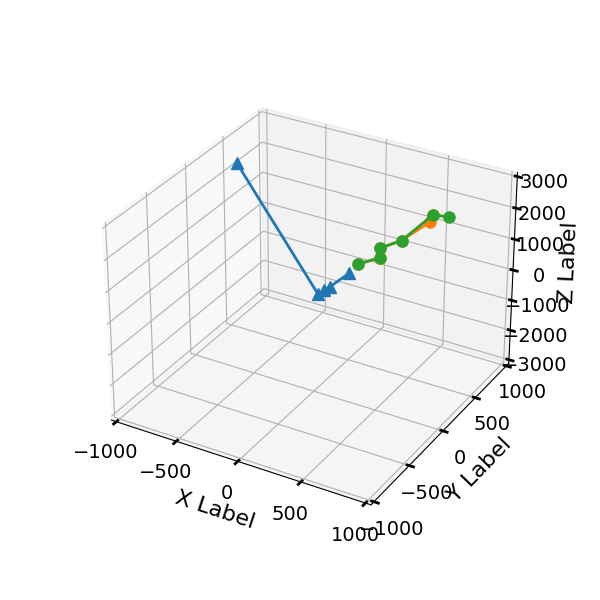

In [176]:
ax = plt.figure(figsize=(6,6)).add_subplot(projection='3d')

ax.plot(seed_positions[0], seed_positions[1], seed_positions[2], marker='^', ms=8)
ax.plot(true_track_positions[0], true_track_positions[1], true_track_positions[2], marker='o', ms=8)
ax.plot(generated_track[0], generated_track[1], generated_track[2], marker='o', ms=8)


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_zlim(-3000, 3000)
ax.set_ylim(-1000, 1000)
ax.set_xlim(-1000, 1000)

In [177]:
def plot(ax1, ax2, track: np.ndarray, *args, **kwargs) -> None:
    """Plot a track from different views"""
    minorsize = 14
    fontsize = 16

    if track.shape[0] != 3:
        raise ValueError("Track must have 3 columns for x, y, and z.")

    if 'lw' not in kwargs:
        kwargs['lw'] = 2

    x = track[0]
    y = track[1]
    z = track[2]
    r = np.sqrt(x**2 + y**2)

    # plot r vs z
    ax1.plot(z, r, *args, **kwargs)
    ax1.set_xlabel("z [m]", fontsize=fontsize)
    ax1.set_ylabel("r [m]", fontsize=fontsize)
    ax1.tick_params(axis='both', which='major', labelsize=minorsize)
    
    # plot x vs y
    ax2.plot(x, y, *args, **kwargs)
    ax2.set_xlabel("x [m]", fontsize=fontsize)
    ax2.set_ylabel("y [m]", fontsize=fontsize)
    ax2.tick_params(axis='both', which='major', labelsize=minorsize)
    

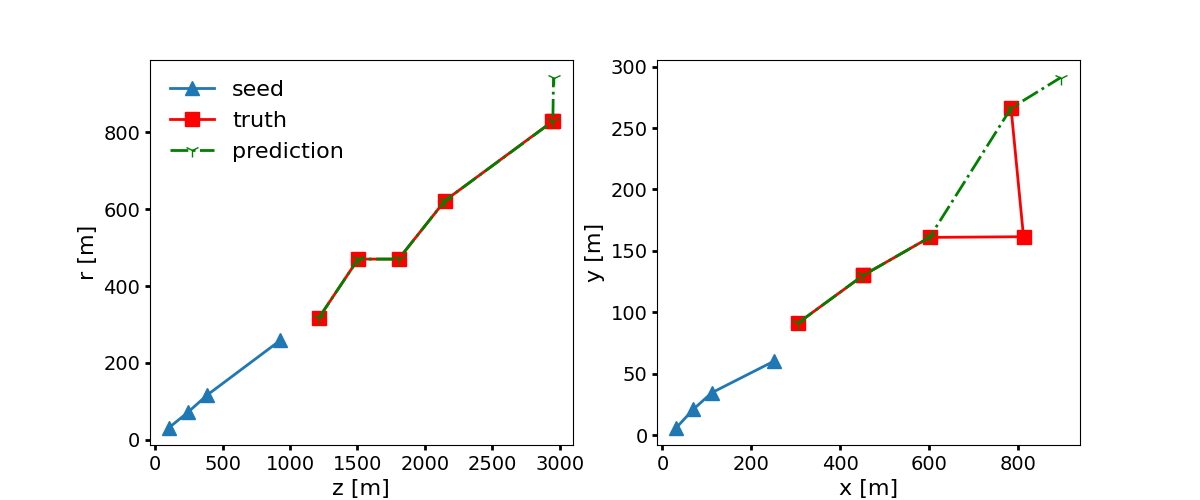

In [179]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plot(ax1, ax2, seed_positions[:, 1:], '-^', ms=10, label="seed")
plot(ax1, ax2, true_track_positions, 'r-s', ms=10, label="truth")
plot(ax1, ax2, generated_track, 'g-.1', ms=10, label="prediction")
ax1.legend();

In [85]:
true_track_positions

array([[ 304.641 ,  451.631 ,  451.631 ,  600.806 ,  812.09  ,  784.058 ],
       [  91.2034,  130.113 ,  130.113 ,  160.985 ,  161.535 ,  266.152 ],
       [1215.5   , 1504.5   , 1804.5   , 2148.5   , 2944.5   , 2947.5   ]])

In [87]:
seed_positions[:, 1:]

array([[ 31.6303 ,  69.1389 , 110.986  , 251.358  ],
       [  6.29166,  20.9731 ,  34.5847 ,  60.3456 ],
       [105.     , 245.     , 385.     , 927.     ]])

In [89]:
seed_positions[:, 0]

array([-784.058,  266.152, 2944.5  ])